利用CNN辨識手寫阿拉伯數字，其實有幾個缺點：
- MNIST 的訓練資料與滑鼠撰寫的樣式有所差異，我猜 MNIST 的資料收集應該是請受測者寫在紙上，再掃描存檔，因此有灰階及鋸齒狀，所以，如果要實際應用，應該自己收集訓練資料。
- 要收集上萬筆受測者的資料，可能不太容易，另外，有些書寫可能字體歪斜、偏一邊、或字體大小不同，我們可以透過【資料增補】(Data Augmentation)方式自動產生這些資料。
- 可以利用預訓模型(Pre-trained Models)，套用大公司訓練好的模型，使辨識更精準。

# 【資料增補】(Data Augmentation)
## 使用自備的訓練資料在PetImages目錄，含貓(Cat)與狗(Dog)次目錄
## 程式修改自Keras官網，資訊如下。

# Image classification from scratch

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/04/27<br>
**Last modified:** 2020/04/28<br>
**Description:** Training an image classifier from scratch on the Kaggle Cats vs Dogs dataset.

## Introduction

This example shows how to do image classification from scratch, starting from JPEG
image files on disk, without leveraging pre-trained weights or a pre-made Keras
Application model. We demonstrate the workflow on the Kaggle Cats vs Dogs binary
 classification dataset.

We use the `image_dataset_from_directory` utility to generate the datasets, and
we use Keras image preprocessing layers for image standardization and data augmentation.


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
tf.__version__

'2.3.2'

[資料集下載連結](https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip)

In [3]:
if 'google.colab' in str(get_ipython()):
    # 下載資料集
    !curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

    # 解壓縮
    !unzip -q kagglecatsanddogs_3367a.zip
else:
    print('pass')

pass


### 過濾不合格的檔案

#### 掃描每一個檔案，若表頭不含"JFIF"，即為不合格的檔案，不納入訓練資料內。


In [4]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)


Deleted 1578 images


## 建立訓練(Training)及驗證(Validation)資料集(Dataset)


In [5]:
# image_dataset_from_directory：tf v2.3.0 才支援
# image_dataset_from_directory：讀取目錄中的檔案，存入 dataset

image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 23422 files belonging to 2 classes.
Using 18738 files for training.
Found 23422 files belonging to 2 classes.
Using 4684 files for validation.


## 顯示訓練資料前9筆影像
### 標注為1是狗(dog)，0是貓(cat)


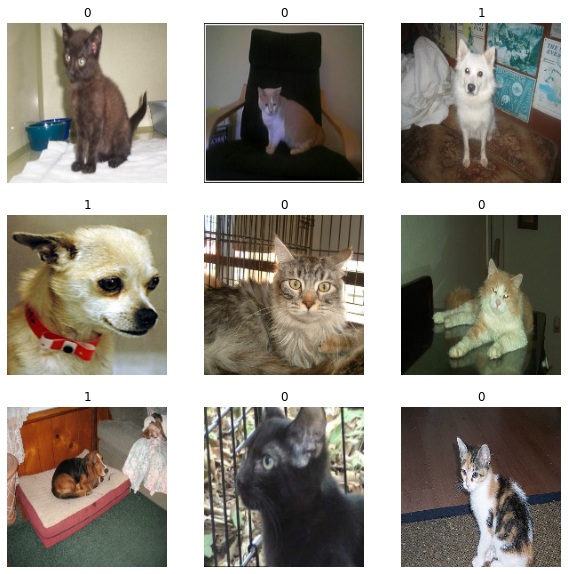

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


## 【資料增補】(Data Augmentation)

In [7]:
# RandomFlip("horizontal")：水平翻轉
# RandomRotation(0.1)：旋轉 0.1 比例 
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)


## 顯示訓練資料前9筆的【資料增補】後的影像


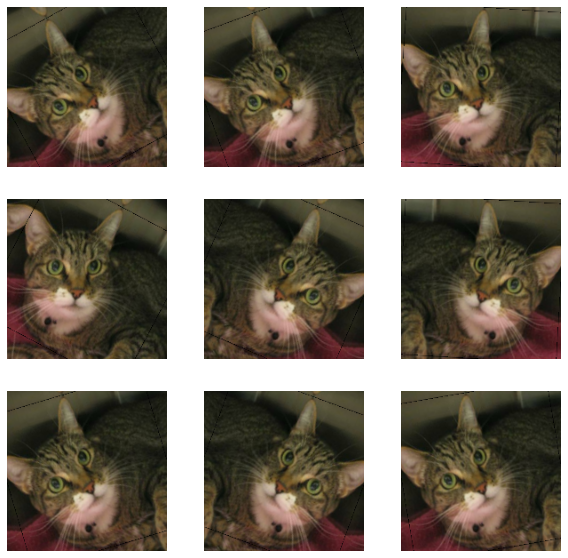

In [8]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


## Standardizing the data

Our image are already in a standard size (180x180), as they are being yielded as
contiguous `float32` batches by our dataset. However, their RGB channel values are in
 the `[0, 255]` range. This is not ideal for a neural network;
in general you should seek to make your input values small. Here, we will
standardize values to be in the `[0, 1]` by using a `Rescaling` layer at the start of
 our model.


## Two options to preprocess the data

There are two ways you could be using the `data_augmentation` preprocessor:

**Option 1: Make it part of the model**, like this:

```python
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.experimental.preprocessing.Rescaling(1./255)(x)
...  # Rest of the model
```

With this option, your data augmentation will happen *on device*, synchronously
with the rest of the model execution, meaning that it will benefit from GPU
 acceleration.

Note that data augmentation is inactive at test time, so the input samples will only be
 augmented during `fit()`, not when calling `evaluate()` or `predict()`.

If you're training on GPU, this is the better option.

**Option 2: apply it to the dataset**, so as to obtain a dataset that yields batches of
 augmented images, like this:

```python
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))
```

With this option, your data augmentation will happen **on CPU**, asynchronously, and will
 be buffered before going into the model.

If you're training on CPU, this is the better option, since it makes data augmentation
 asynchronous and non-blocking.

In our case, we'll go with the first option.


## prefetch：預先讀取訓練資料，以提升效能

In [9]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)


## 建立模型
BatchNormalization layer 是將輸出標準化，通常可增加準確度。

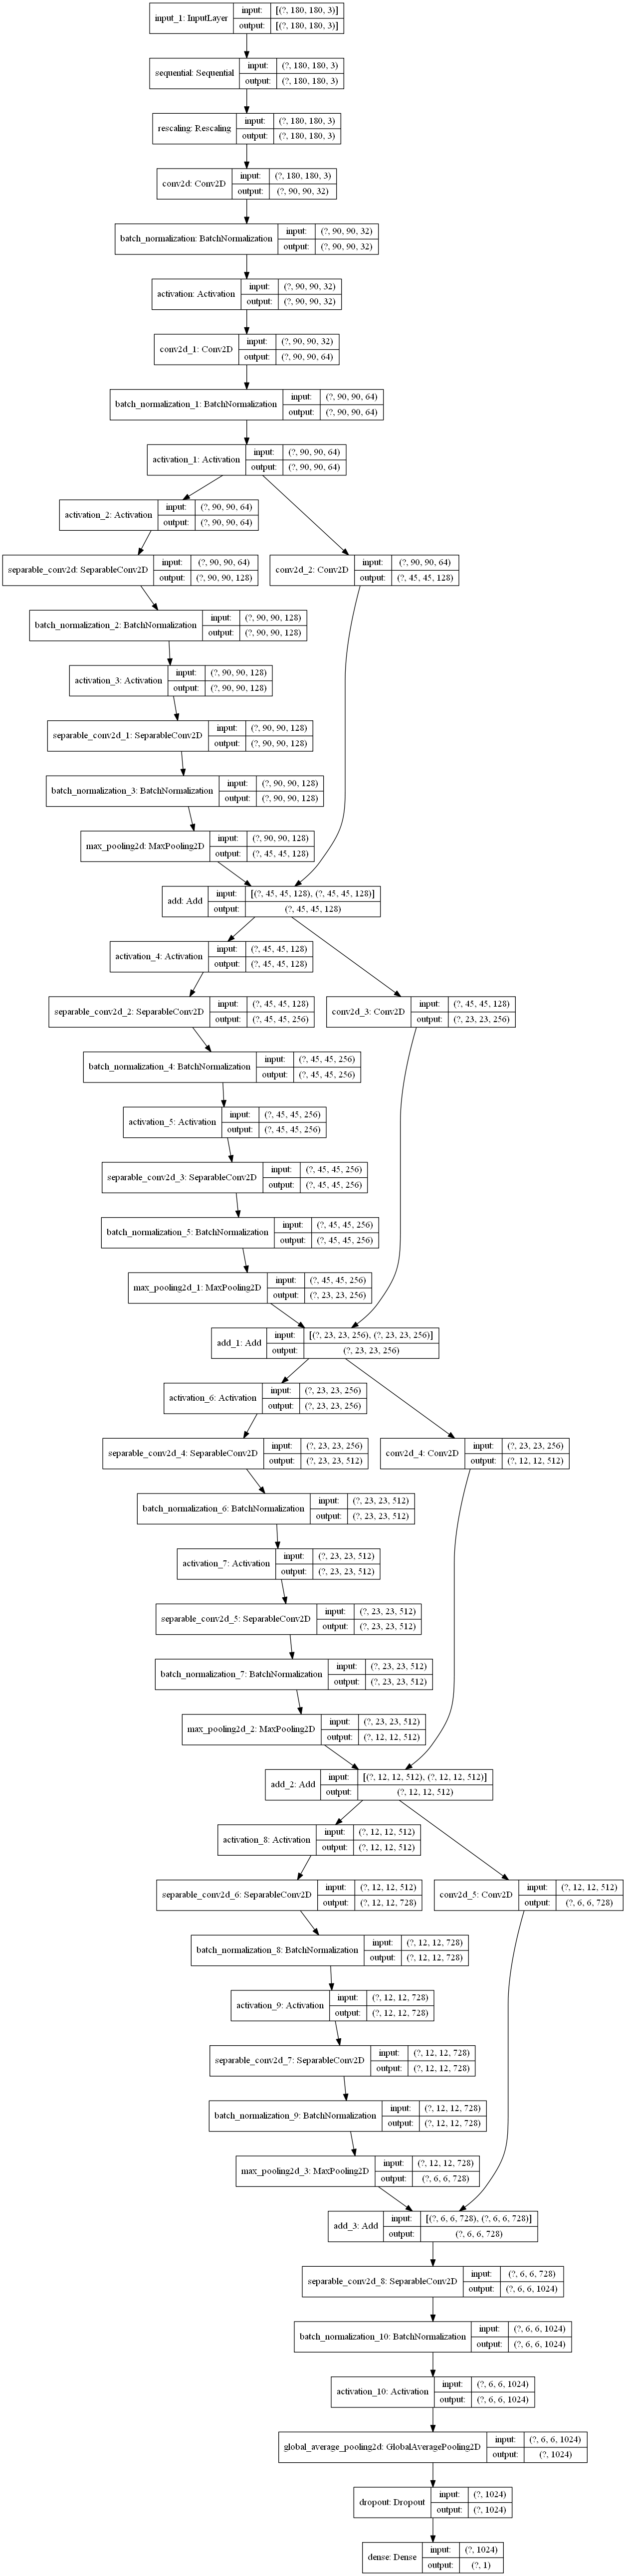

In [10]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


## 訓練模型

In [11]:
epochs = 5

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
# compile時要加入上面callback參數才會存檔
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, validation_data=val_ds, # , callbacks=callbacks
)


Epoch 1/5
586/586 [==============================] - 137s 234ms/step - loss: 0.6243 - accuracy: 0.6672 - val_loss: 0.5060 - val_accuracy: 0.7549
Epoch 2/5
586/586 [==============================] - 137s 234ms/step - loss: 0.4741 - accuracy: 0.7771 - val_loss: 0.3906 - val_accuracy: 0.8292
Epoch 3/5
586/586 [==============================] - 139s 238ms/step - loss: 0.3751 - accuracy: 0.8322 - val_loss: 0.3990 - val_accuracy: 0.8318
Epoch 4/5
586/586 [==============================] - 142s 243ms/step - loss: 0.3092 - accuracy: 0.8680 - val_loss: 0.2551 - val_accuracy: 0.8971
Epoch 5/5
586/586 [==============================] - 134s 229ms/step - loss: 0.2559 - accuracy: 0.8934 - val_loss: 0.2000 - val_accuracy: 0.9208


#### 訓練50 epochs，驗證準確率約 96%.

## 任取一筆資料測試

In [12]:
img = keras.preprocessing.image.load_img(
    "./PetImages/Cat/18.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)


This image is 80.82 percent cat and 19.18 percent dog.
